In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time

In [2]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=86400000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    intervals_dict = {"1m": 60000, "5m": 300000, "15m": 900000, "30m": 1800000, "1h": 3600000, "3h": 10800000, "6h": 21600000, "12h": 43200000, "1D": 86400000, "7D": 604800000, "14D": 1209600000, "1M": 2628000000}
    step = intervals_dict[interval] * 1000
    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 1000 * interval
        while start < stop:
            if start + step > stop: # if start + 1000 * interval > stop ==> stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [3]:
pair = 'egld:usd'
interval = '1h'

t_start = datetime(2020, 5, 13, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [4]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=interval)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2020-09-10 10:00:00,22.000,15.411,22.000,9.888,1460.870000
1,2020-09-10 11:00:00,15.373,15.278,15.373,15.278,1563.641000
2,2020-09-10 12:00:00,15.327,15.401,15.401,15.327,1290.066000
3,2020-09-10 13:00:00,15.355,15.309,15.355,15.276,1254.975800
4,2020-09-10 14:00:00,15.276,15.230,15.319,15.225,278.504858
...,...,...,...,...,...,...
14752,2022-05-20 08:00:00,90.404,90.531,91.330,90.133,44.903272
14753,2022-05-20 09:00:00,90.582,91.699,91.923,90.581,26.847215
14754,2022-05-20 10:00:00,91.531,92.291,92.447,91.531,34.376053
14755,2022-05-20 11:00:00,92.355,93.036,93.479,91.883,146.476457


In [7]:
df1=df.reset_index()['close']

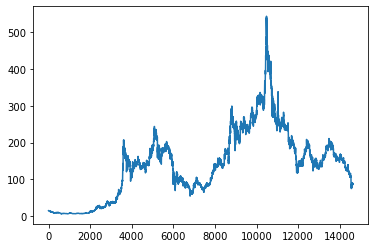

In [8]:
plt.plot(df1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(9512, 5122)

In [13]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(9411, 100)
(9411,)
(5021, 100)
(5021,)


(None, None)

In [17]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
148/148 [==============================] - 50s 223ms/step - loss: 0.0015 - val_loss: 4.4597e-04
Epoch 2/100
148/148 [==============================] - 31s 209ms/step - loss: 1.1908e-04 - val_loss: 4.5970e-04
Epoch 3/100
148/148 [==============================] - 33s 226ms/step - loss: 1.1319e-04 - val_loss: 4.5387e-04
Epoch 4/100
148/148 [==============================] - 32s 213ms/step - loss: 1.0393e-04 - val_loss: 2.6340e-04
Epoch 5/100
148/148 [==============================] - 31s 207ms/step - loss: 9.7827e-05 - val_loss: 2.3210e-04
Epoch 6/100
148/148 [==============================] - 32s 214ms/step - loss: 9.0122e-05 - val_loss: 2.6456e-04
Epoch 7/100
148/148 [==============================] - 29s 197ms/step - loss: 8.3456e-05 - val_loss: 1.9566e-04
Epoch 8/100
148/148 [==============================] - 37s 247ms/step - loss: 7.9828e-05 - val_loss: 1.8424e-04
Epoch 9/100
148/148 [==============================] - 37s 251ms/step - loss: 7.1388e-05 - val_loss: 1.6026e

In [22]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [23]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

123.72984477073256

In [25]:
math.sqrt(mean_squared_error(ytest,test_predict))

222.65449106284484

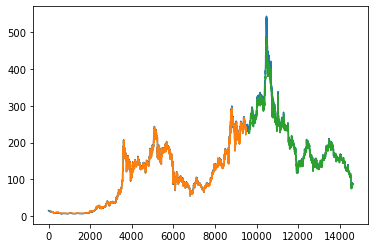

In [26]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
len(test_data)

5122

In [28]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [29]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [30]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.15077922]
101
1 day input [0.18850815 0.18959019 0.19069088 0.18804175 0.18679181 0.16436189
 0.17638185 0.17798625 0.17045116 0.15266281 0.14920775 0.14945401
 0.14577694 0.13803663 0.14889806 0.14677503 0.14639632 0.14796154
 0.14842421 0.14537211 0.14295431 0.14061674 0.13035789 0.12814531
 0.13996938 0.13497707 0.13546026 0.14219315 0.13979961 0.14045256
 0.13668035 0.14081635 0.1404563  0.14310543 0.13943582 0.13284471
 0.13563749 0.13384467 0.13101644 0.13080376 0.13312455 0.13567294
 0.13614493 0.14073054 0.14821153 0.1484354  0.15450228 0.15346128
 0.14920962 0.15731931 0.15835658 0.15230835 0.15357508 0.15185875
 0.15065731 0.14961445 0.14926745 0.15019838 0.14902679 0.15195762
 0.15050806 0.14984951 0.15156772 0.15001182 0.15134571 0.15189979
 0.15218709 0.15199493 0.15028419 0.15024315 0.14711083 0.14944655
 0.14974504 0.15031964 0.14988309 0.14909022 0.14906597 0.14907716
 0.14757163 0.14777312 0.14657914 0.14868725 0.14931409 0.15029725
 0.14973198 0.14923574 0.15025994

In [31]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [32]:
scaler.inverse_transform(lst_output)

array([[87.46634513],
       [87.07659213],
       [86.7006813 ],
       [86.3388762 ],
       [85.9818236 ],
       [85.62429177],
       [85.26447553],
       [84.90311773],
       [84.54206345],
       [84.18309388],
       [83.82728732],
       [83.47499521],
       [83.12605781],
       [82.78007575],
       [82.43660173],
       [82.09534022],
       [81.75615543],
       [81.41911126],
       [81.08435948],
       [80.75209177],
       [80.42254777],
       [80.09595112],
       [79.77245358],
       [79.45222288],
       [79.13534689],
       [78.82188951],
       [78.51189066],
       [78.20535835],
       [77.90231653],
       [77.60274124]])

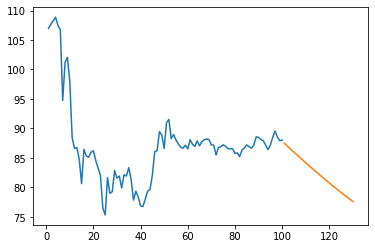

In [34]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

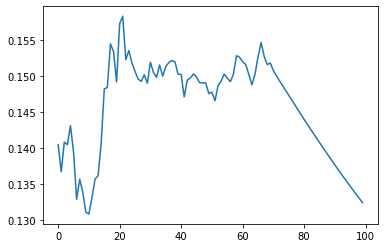

In [50]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[-100:])

In [51]:
df3=scaler.inverse_transform(df3).tolist()

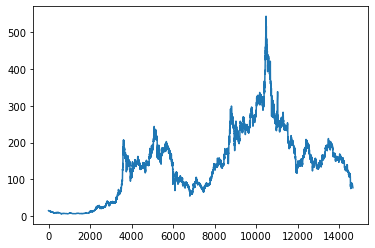

In [52]:
plt.plot(df3)